# Machine Learning

## (1)Setup

In [1]:
%pylab inline
import os
import glob
import pandas as pd
import time
import sklearn
import seaborn as sns
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# (2)Read data 

In [363]:
Autism = pd.read_csv(Path+'/labeled.csv', encoding='latin-1')
Autism = Autism.reset_index()

# First we need to convert PI_IDS into a string variable
Autism['PI_IDS'] = Autism['PI_IDS'].astype(str)

# Make a temperary dataframe that creates an observation for each PI. 
# Use the explode function to split the PI_IDS at the ;
temp = Autism['PI_IDS'].str.split(';').explode().reset_index()

# Rename the PI_IDS variable
temp = temp.rename(columns = {'PI_IDS': 'PI_ID'})

# Replace " " with and emplty string
temp['PI_ID'] = temp['PI_ID'].str.replace(' ','')

# Only keep observations in the temp dataframe where PI_ID is not an empty string or a sting with a single space
temp = temp[temp['PI_ID'] !=""]
temp = temp[temp['PI_ID'] !=" "]
temp = temp[temp['PI_ID'] !="  "]

# For the the PI_ID variable, use the str.replace fundtion to replace ` (contact)` with nothing 
temp['PI_ID'] = temp['PI_ID'].str.replace('\(contact\)', '')

# Merge this temperary dataframe
Autism_1 = Autism.merge(temp, on = 'index')

Autism_1.head(5)


,index,APPLICATION_ID,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_START,Start Year,BUDGET_END,...,SUFFIX,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,TOTAL_COST_SUB_PROJECT,Priority,New,topic,PI_ID
0,0,9218971,U01,MH,1,N,4/4/2017,4/5/2017,2017,1/31/2018,...,NaN,1,174188.0,101900.0,276088.0,NaN,0,1,"genet, risk, genom, gene, environment, exposur...",10646297
1,0,9218971,U01,MH,1,N,4/4/2017,4/5/2017,2017,1/31/2018,...,NaN,1,174188.0,101900.0,276088.0,NaN,0,1,"genet, risk, genom, gene, environment, exposur...",6475210
2,1,9273636,K01,MH,5,N,4/19/2017,5/1/2017,2017,4/30/2018,...,NaN,2,140314.0,11225.0,151539.0,NaN,0,0,"brain, connect, imag, neural, mri, function, n...",12219780
3,2,9398842,R01,HD,1,N,9/5/2017,9/6/2017,2017,6/30/2018,...,A1,1,411446.0,138691.0,550137.0,NaN,1,1,"earli, infant, children, age, month, outcom, m...",10007322
4,3,9329224,R13,ES,1,N,2/17/2017,4/1/2017,2017,3/31/2018,...,NaN,1,8000.0,NaN,8000.0,NaN,1,1,"train, servic, communiti, center, core, implem...",1867188


In [364]:
#filter out biomedical(non-priority) PIs in 2016
Autism_2016=Autism_1.loc[(Autism_1['FY']==2016) & (Autism_1['Priority']==0)]
                          
Autism_2016.shape

(419, 51)

# (3)Create lable

In [365]:
#filter out data from 2017 to 2021 to see if these PIs who have social area research in that period of time.
lb = Autism_1.loc[(Autism_1['FY']>2016) & (Autism_1['Priority']==1)]

lb = lb.reset_index()

lb.head(5)


,level_0,index,APPLICATION_ID,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_START,Start Year,...,SUFFIX,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,TOTAL_COST_SUB_PROJECT,Priority,New,topic,PI_ID
0,3,2,9398842,R01,HD,1,N,9/5/2017,9/6/2017,2017,...,A1,1,411446.0,138691.0,550137.0,NaN,1,1,"earli, infant, children, age, month, outcom, m...",10007322
1,4,3,9329224,R13,ES,1,N,2/17/2017,4/1/2017,2017,...,NaN,1,8000.0,NaN,8000.0,NaN,1,1,"train, servic, communiti, center, core, implem...",1867188
2,8,7,9377310,R01,MH,1,N,7/14/2017,8/1/2017,2017,...,NaN,1,256701.0,197660.0,454361.0,NaN,1,1,"earli, infant, children, age, month, outcom, m...",10786102
3,13,12,9451815,R21,HD,1,N,9/19/2017,9/19/2017,2017,...,A1,1,145330.0,83743.0,229073.0,NaN,1,1,"train, servic, communiti, center, core, implem...",8752515
4,18,16,9355709,UG3,OD,5,N,8/30/2017,9/1/2017,2017,...,NaN,2,3470797.0,863563.0,3668723.0,NaN,1,0,"earli, infant, children, age, month, outcom, m...",1911715


In [366]:
lb = lb[['PI_ID']].drop_duplicates()
lb['Social'] = 1
lb.shape

(328, 2)

In [367]:
CP2 = pd.merge(Autism_2016, lb, on='PI_ID', how = 'left').drop_duplicates()
CP2['Social'] =CP2['Social'].fillna(0)

CP2.head(5)

,index,APPLICATION_ID,ACTIVITY,ADMINISTERING_IC,APPLICATION_TYPE,ARRA_FUNDED,AWARD_NOTICE_DATE,BUDGET_START,Start Year,BUDGET_END,...,SUPPORT_YEAR,DIRECT_COST_AMT,INDIRECT_COST_AMT,TOTAL_COST,TOTAL_COST_SUB_PROJECT,Priority,New,topic,PI_ID,Social
0,475,9029863,R01,MH,1,N,12/17/2015,1/1/2016,2016,11/30/2016,...,1,457570.0,244604.0,702174.0,NaN,0,1,"social, deficit, languag, cognit, impair, lear...",7927760,1.0
1,476,9070784,F31,MH,5,N,5/25/2016,6/1/2016,2016,3/31/2017,...,3,27023.0,NaN,27023.0,NaN,0,0,"syndrom, x, model, fragil, fragil x, intellect...",11055390,0.0
2,477,9101609,R01,MH,1,N,8/1/2016,8/1/2016,2016,6/30/2017,...,1,142630.0,83439.0,226069.0,NaN,0,1,"genet, risk, genom, gene, environment, exposur...",10646297,0.0
3,477,9101609,R01,MH,1,N,8/1/2016,8/1/2016,2016,6/30/2017,...,1,142630.0,83439.0,226069.0,NaN,0,1,"genet, risk, genom, gene, environment, exposur...",6475210,0.0
4,477,9101609,R01,MH,1,N,8/1/2016,8/1/2016,2016,6/30/2017,...,1,142630.0,83439.0,226069.0,NaN,0,1,"genet, risk, genom, gene, environment, exposur...",12522190,0.0


In [368]:
MD= CP2[['PI_ID','Social']]
MD

,PI_ID,Social
0,7927760,1.0
1,11055390,0.0
2,10646297,0.0
3,6475210,0.0
4,12522190,0.0
...,...,...
414,1982839,0.0
415,1882597,1.0
416,8735036,0.0
417,7889571,0.0


# (4) Create features.

#feature 1 NIH spending cats.

In [369]:
    # convert NIH spending cats into a string variable
CP2['NIH_SPENDING_CATS'] = CP2['NIH_SPENDING_CATS'].astype(str)

# Make a temporary dataframe that creates an observation for each spending catagory
# Use the explode function to split the NIH_SPENDING_CATS at the ;
temp = Autism_2016['NIH_SPENDING_CATS'].str.split(';').explode().reset_index()

# Rename the NIH_SPENDING_CATS variable
temp = temp.rename(columns = {'NIH_SPENDING_CATS': 'NIH_SPENDING_CAT'})

# Replace " " with and emplty string
temp['NIH_SPENDING_CAT'] = temp['NIH_SPENDING_CAT'].str.replace(' ','')


# Only keep observations in the temp dataframe where PI_ID is not an empty string
temp = temp[temp['NIH_SPENDING_CAT'] !=""]
#temp = temp.drop(columns=['index'])

#temp['index'] = temp.index
#temp.shape
temp

,index,NIH_SPENDING_CAT
0,586,Autism
1,586,BasicBehavioralandSocialScience
2,586,BehavioralandSocialScience
3,586,BrainDisorders
4,586,ClinicalResearch
...,...,...
4692,1148,HumanGenome
4693,1148,IntellectualandDevelopmentalDisabilities(IDD)
4694,1148,MentalHealth
4695,1148,Neurosciences


In [370]:
#Autism_2016=Autism_2016.reset_index()
ft=Autism_2016[['PI_ID','NIH_SPENDING_CATS']].reset_index()

#ft = ft.drop(columns=['index']
ft = ft.rename(columns={'level_0': 'index'})

ft

,index,PI_ID,NIH_SPENDING_CATS
0,586,7927760,Autism; Basic Behavioral and Social Science; B...
1,587,11055390,Autism; Brain Disorders; Fragile X Syndrome; G...
2,588,10646297,Autism; Biotechnology; Brain Disorders; Geneti...
3,589,6475210,Autism; Biotechnology; Brain Disorders; Geneti...
4,590,12522190,Autism; Biotechnology; Brain Disorders; Geneti...
...,...,...,...
414,1143,1982839,Autism; Basic Behavioral and Social Science; B...
415,1144,1882597,Autism; Biotechnology; Brain Disorders; Geneti...
416,1145,8735036,Autism; Brain Disorders; Clinical Research; In...
417,1147,7889571,Autism; Basic Behavioral and Social Science; B...


In [371]:

ft1_2 = pd.merge(ft,temp, on = 'index',how='inner')

ft1_2 = ft1_2.drop(columns=['index', 'NIH_SPENDING_CATS'])

# Drop duplicate observations
ft1_2 = ft1_2.drop_duplicates()
ft1_2['Cat'] = 1


ft1_2.head()


,PI_ID,NIH_SPENDING_CAT,Cat
0,7927760,Autism,1
1,7927760,BasicBehavioralandSocialScience,1
2,7927760,BehavioralandSocialScience,1
3,7927760,BrainDisorders,1
4,7927760,ClinicalResearch,1


In [372]:
ft1_3 = pd.pivot(ft1_2, index='PI_ID', columns = 'NIH_SPENDING_CAT',values = 'Cat')

cols = ft1_2['NIH_SPENDING_CAT'].unique()
ft1_3=ft1_3[cols]

ft1_3 = ft1_3.fillna(0)

ft1_3.head()


NIH_SPENDING_CAT,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,Pediatric,FragileXSyndrome,...,DownSyndrome,Post-TraumaticStressDisorder(PTSD),AutoimmuneDisease,"Preterm,LowBirthWeightandHealthoftheNewborn",Injury(total)Accidents/AdverseEffects,Injury-UnintentionalChildhoodInjury,PeripheralNeuropathy,BackPain,PainConditions-Chronic,PainResearch
PI_ID,,,,,,,,,,,,,,,,,,,,,
10041622,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10068326,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10079282,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10083938,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10220744,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [373]:
#merge back to CP2
MD = pd.merge(MD, ft1_3, on = 'PI_ID',  how = 'left')
MD.shape

(419, 101)

 # feature 2 total cost of projects

In [374]:
    # NIH reporter data has both total cost and sub project cost. Those without total cost has correpsonding sub proeject cost
    # I consider the combination of these two columns as the real cost.
    Cost_total = CP2.groupby(['PI_ID'])['TOTAL_COST'].sum()
    Cost_sub = CP2.groupby(['PI_ID'])['TOTAL_COST_SUB_PROJECT'].sum()
    # Convert into a dataframe and reset index
    Cost_total = Cost_total.to_frame().reset_index()
    Cost_sub = Cost_sub.to_frame().reset_index()
    # drop first row
    Cost_total = Cost_total.iloc[1:, :]
    Cost_sub = Cost_sub.iloc[1:, :]
    # View the first 5 observations 

    Cost = pd.merge(Cost_total,Cost_sub,on='PI_ID')
    Cost['Cost']=Cost['TOTAL_COST']+Cost['TOTAL_COST_SUB_PROJECT']
    Cost = Cost.drop(columns=['TOTAL_COST', 'TOTAL_COST_SUB_PROJECT'])
 
    Cost.head(5)

,PI_ID,Cost
0,10068326,126066.0
1,10079282,1.0
2,10083938,147905.0
3,10220744,428200.0
4,10234449,318230.0


In [375]:
MD = pd.merge(MD, Cost, on = 'PI_ID',  how = 'left')
MD.head()

,PI_ID,Social,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,...,Post-TraumaticStressDisorder(PTSD),AutoimmuneDisease,"Preterm,LowBirthWeightandHealthoftheNewborn",Injury(total)Accidents/AdverseEffects,Injury-UnintentionalChildhoodInjury,PeripheralNeuropathy,BackPain,PainConditions-Chronic,PainResearch,Cost
0,7927760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,702174.0
1,11055390,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27023.0
2,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549683.0
3,6475210,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6596500.0
4,12522190,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549683.0


# feature 3, number of Austism reaserch in 2016

In [376]:
#first filter out all 2016 data
ft3=Autism_1.loc[(Autism_1['FY']==2016) ]
temp = ft3.groupby(['PI_ID'])['APPLICATION_ID'].nunique().sort_values(ascending=False)
temp = temp.to_frame().reset_index()
temp.rename(columns={'APPLICATION_ID':'Total_Autism_Projects_2016'}, inplace = True)

temp.head(5)


,PI_ID,Total_Autism_Projects_2016
0,7753308,8
1,6475210,7
2,1965917,5
3,6872358,4
4,1882597,4


In [377]:
MD = pd.merge(MD, temp, on = 'PI_ID',  how = 'inner')

MD.head()

,PI_ID,Social,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,...,AutoimmuneDisease,"Preterm,LowBirthWeightandHealthoftheNewborn",Injury(total)Accidents/AdverseEffects,Injury-UnintentionalChildhoodInjury,PeripheralNeuropathy,BackPain,PainConditions-Chronic,PainResearch,Cost,Total_Autism_Projects_2016
0,7927760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,702174.0,2
1,11055390,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27023.0,1
2,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549683.0,2
3,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549683.0,2
4,6475210,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6596500.0,7


# feature 4 Number of Social area Autism projcts by orginization in 2016

In [378]:
Autism_2016_p=Autism_1.loc[(Autism_1['FY']==2016) & (Autism_1['Priority']==1)]
ft4 = Autism_2016_p.groupby(['ORG_NAME'])['APPLICATION_ID'].nunique().sort_values(ascending=False)

# Convert into a dataframe and reset index
ft4 = ft4.to_frame().reset_index()

# Rename APPLICATION_ID to Total_BC_Projects_by_ORG
ft4.rename(columns={'APPLICATION_ID':'Total_Autism_Projects_by_ORG'}, inplace = True)

# View the first 5 observations 
ft4.head()

,ORG_NAME,Total_Autism_Projects_by_ORG
0,EMORY UNIVERSITY,12
1,UNIVERSITY OF CALIFORNIA AT DAVIS,10
2,UNIVERSITY OF CALIFORNIA LOS ANGELES,5
3,UNIVERSITY OF PENNSYLVANIA,4
4,UNIV OF NORTH CAROLINA CHAPEL HILL,3


In [379]:
ft4_1 = pd.merge(CP2, ft4, on = 'ORG_NAME',  how = 'left')
ft4_1=ft4_1.drop_duplicates()

ft4_2 = ft4_1.groupby(['PI_ID'])['Total_Autism_Projects_by_ORG'].sum()
ft4_2 = ft4_2.to_frame().reset_index()

ft4_2.head()


,PI_ID,Total_Autism_Projects_by_ORG
0,10041622,0.0
1,10068326,1.0
2,10079282,0.0
3,10083938,1.0
4,10220744,0.0


In [380]:
ft4_2['Total_Autism_Projects_by_ORG'].describe()

#in our case, the number of social area research is pretty small. I would like to seperate them into no-social area project, 1 to 3
#and more than 3

count    338.000000
mean       2.606509
std        4.158815
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max       24.000000
Name: Total_Autism_Projects_by_ORG, dtype: float64

In [381]:
No = ft4_2[ft4_2['Total_Autism_Projects_by_ORG'] == 0]

No['Org_No'] = 1

No = No[['PI_ID', 'Org_No']]

MD = pd.merge(MD, No, on = 'PI_ID',  how = 'left')



In [382]:
MD['Org_No'] = MD['Org_No'].fillna(0)
MD.shape
MD.head()

,PI_ID,Social,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,...,"Preterm,LowBirthWeightandHealthoftheNewborn",Injury(total)Accidents/AdverseEffects,Injury-UnintentionalChildhoodInjury,PeripheralNeuropathy,BackPain,PainConditions-Chronic,PainResearch,Cost,Total_Autism_Projects_2016,Org_No
0,7927760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,702174.0,2,0.0
1,11055390,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27023.0,1,0.0
2,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549683.0,2,0.0
3,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549683.0,2,0.0
4,6475210,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6596500.0,7,0.0


In [383]:
#[1,3] projects as few
Few = ft4_2[ft4_2['Total_Autism_Projects_by_ORG'] >= 1]
Few = Few[Few['Total_Autism_Projects_by_ORG'] <= 3]

Few['Org_Few'] = 1


Few = Few[['PI_ID', 'Org_Few']]

MD = pd.merge(MD, Few, on = 'PI_ID',  how = 'left')



In [384]:
MD['Org_Few'] = MD['Org_Few'].fillna(0)

MD.head()

,PI_ID,Social,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,...,Injury(total)Accidents/AdverseEffects,Injury-UnintentionalChildhoodInjury,PeripheralNeuropathy,BackPain,PainConditions-Chronic,PainResearch,Cost,Total_Autism_Projects_2016,Org_No,Org_Few
0,7927760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,702174.0,2,0.0,0.0
1,11055390,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,27023.0,1,0.0,1.0
2,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,549683.0,2,0.0,1.0
3,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,549683.0,2,0.0,1.0
4,6475210,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6596500.0,7,0.0,0.0


In [385]:
# More than 3 projects as large

large = ft4_2[ft4_2['Total_Autism_Projects_by_ORG'] > 3]

large['Org_large'] = 1

large = large[['PI_ID', 'Org_large']]

MD = pd.merge(MD, large, on = 'PI_ID',  how = 'left')


In [386]:
MD['Org_large'] = MD['Org_large'].fillna(0)

MD.head()

,PI_ID,Social,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,...,Injury-UnintentionalChildhoodInjury,PeripheralNeuropathy,BackPain,PainConditions-Chronic,PainResearch,Cost,Total_Autism_Projects_2016,Org_No,Org_Few,Org_large
0,7927760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,702174.0,2,0.0,0.0,1.0
1,11055390,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,27023.0,1,0.0,1.0,0.0
2,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,549683.0,2,0.0,1.0,0.0
3,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,549683.0,2,0.0,1.0,0.0
4,6475210,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,6596500.0,7,0.0,0.0,1.0


# feature 5 state of the PI

In [397]:
ft5 = CP2[['PI_ID', 'ORG_STATE']]

ft5 = ft5.drop_duplicates()

ft5['st']=1

ft5_1=pd.pivot(ft5, index='PI_ID', columns = 'ORG_STATE',values = 'st')

ft5_1.fillna(0, inplace=True)

ft5_1.head()

ORG_STATE,CA,CO,CT,DC,DE,FL,GA,IA,IL,IN,...,PA,RI,SC,TN,TX,UT,VA,VT,WA,WI
PI_ID,,,,,,,,,,,,,,,,,,,,,
10041622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10068326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10079282,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10083938,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10220744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [398]:
MD = pd.merge(MD,ft5_1,on='PI_ID',how = 'left')
MD.shape

(419, 140)

In [420]:
# Normalization of total cost
features_to_normalize = ['Cost']

MD[features_to_normalize] = MD[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min())) 
MD.fillna(0,inplace=True)
MD.head()

,PI_ID,Social,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,...,PA,RI,SC,TN,TX,UT,VA,VT,WA,WI
0,7927760,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11055390,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10646297,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6475210,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [447]:
# Our dataset is pretty unbalenced. 90% percent are in biomedical, only 10% in soical.
balance = MD['Social'].value_counts(normalize=True)
balance

0.0    0.897375
1.0    0.102625
Name: Social, dtype: float64

# (5) Split the dataset

In [448]:
df_train, df_test = train_test_split(MD, test_size=0.2)

In [449]:
df_train.describe()

,Social,Autism,BasicBehavioralandSocialScience,BehavioralandSocialScience,BrainDisorders,ClinicalResearch,IntellectualandDevelopmentalDisabilities(IDD),MentalHealth,Neurosciences,Pediatric,...,PA,RI,SC,TN,TX,UT,VA,VT,WA,WI
count,335.000000,335.0,335.000000,335.000000,335.0,335.000000,335.0,335.0,335.000000,335.000000,...,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,0.083582,1.0,0.510448,0.680597,1.0,0.447761,1.0,1.0,0.862687,0.874627,...,0.050746,0.005970,0.005970,0.032836,0.026866,0.014925,0.008955,0.002985,0.023881,0.032836
std,0.277174,0.0,0.500639,0.466943,0.0,0.498007,0.0,0.0,0.344693,0.331637,...,0.219807,0.077151,0.077151,0.178473,0.161933,0.121436,0.094348,0.054636,0.152906,0.178473
min,0.000000,1.0,0.000000,0.000000,1.0,0.000000,1.0,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.0,0.000000,0.000000,1.0,0.000000,1.0,1.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.0,1.000000,1.000000,1.0,0.000000,1.0,1.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# (6)Build the model

In [450]:
X_train = df_train.drop(columns=['Social'])
y_train = df_train['Social']
X_test = df_test.drop(columns=['Social'])
y_test = df_test['Social']

In [451]:
from sklearn import linear_model

model = linear_model.LogisticRegression(max_iter = 100, intercept_scaling = 2, solver = "lbfgs")

model.fit( X_train, y_train)

print(model)

LogisticRegression(intercept_scaling=2)


In [452]:
y_scores = model.predict_proba(X_test)[:,1]

<AxesSubplot:>

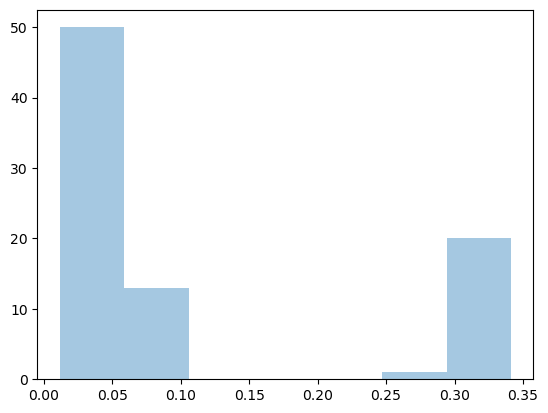

In [453]:
sns.distplot(y_scores, kde=False, rug=False)

In [454]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array( [calc_threshold(score,0.34) for score in y_scores] )
expected = y_test

In [455]:
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.8333333333333334


In [456]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)
print(conf_matrix)


[[68  1]
 [13  2]]


In [459]:
from sklearn.ensemble import RandomForestClassifier

In [460]:
classifier = RandomForestClassifier(n_estimators = 100,random_state=42) 
classifier.fit(X_train, y_train)

# make predictions on the testing data
y_pred = classifier.predict(X_test)

In [461]:
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8571428571428571


In [463]:
from sklearn.metrics import confusion_matrix
conf_matrix_rf = confusion_matrix(y_test,y_pred)
print(conf_matrix_rf)


[[69  0]
 [12  3]]


# Evaluation

In [ ]:
#I want to use logistic regression as the baseline model then run a random forest to get a better model.
# In the logistic model, the accuracy is 83% while it is 86% in random forest which is a little bit of improvement. 
# And for precision and recall, the precision of logistic is 98% for random forest is 100%. Recall for logistic is 84% and 
#85 for random forest.
#The confusion matrix is werid but random forest performs better in every aspects.
